# Introduction

Howdy, folks! This project aims to enhance low-resolution images into high-resolution ones.

To achieve this goal, we will be deploying the Super-Resolution Convolutional Neural Network (SRCNN) using Tensorflow, along with a Fast Non-local Means Denoiser as a pre-processor. This network was introduced in the paper, "Image Super-Resolution Using Deep Convolutional Networks" by Chao Dong et al. (2014). You can read the full paper at https://arxiv.org/abs/1501.00092.

Since computational resources are limited, we'll be focusing on training the model with around 50 sample images from the [LSDIR Dataset](https://data.vision.ee.ethz.ch/yawli/index.html) (=.=)

# Getting Started

Mounting Google Drive to access downloaded datasets and save model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/origin/ .   # 50 HR images

In [ ]:
import os
!mkdir test
for i in range(41, 51):     # split around 20% images to 'test'
  filename = f"00000{i}.png"
  !mv origin/{filename} test/{filename}


# Required Libraries and Functions

In [ ]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage

from keras.models import Sequential
from keras.layers import Conv2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# Image Quality Metrics

Functions that we can use to calculate the PSNR, MSE, and SSIM. We will have to define our functions for the PSNR and MSE. The structural similiarity (SSIM) index was imported directly from the scikit-image library.

**Structural Similarity Index Measure (SSIM)**

This metric goes beyond simple pixel differences.
It compares various aspects of image structure, including luminance (brightness), contrast, and perceived texture. SSIM values range from 0 to 1, with a higher score indicating greater structural similarity between the original and processed image. SSIM aims to better reflect how humans perceive image quality.

**Mean squared error (MSE)**

A lower MSE indicates a smaller difference between the images, suggesting higher quality. However, MSE doesn't account for human perception - large errors in bright areas might affect us more than those in shadows, which MSE doesn't consider.

**Peak signal-to-noise ratio (PSNR)**

Higher PSNR indicates a better quality image. While PSNR is convenient, it also suffers from the limitations of MSE - focusing only on pixel intensity differences and not considering human visual perception.

In [ ]:
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

def psnr(target, ref):
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

from skimage.metrics import structural_similarity as ssim

# combination of all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))

    return scores

In [ ]:
DATA_PATH = "origin"
TEST_PATH = "test"
BLOCK_STEP = 16
BLOCK_SIZE = 32
RANDOM_CROP = 30
PATCH_SIZE = 32
LABEL_SIZE = 20
CONV_SIDE = 6
SCALE = 2

In [ ]:
def prepare_data(_path):
  '''for building the test images'''
  names = os.listdir(_path)
  names = sorted(names)
  nums = names.__len__()
  #define two arrays to hold all the data images and their corresponding label images
  data = np.zeros((nums * RANDOM_CROP, 1, PATCH_SIZE, PATCH_SIZE), dtype=np.double)
  label = np.zeros((nums * RANDOM_CROP, 1, LABEL_SIZE, LABEL_SIZE), dtype=np.double)

  for i in range(nums):
    name = os.path.join(_path , names[i])
    #read the image that is a highy resolution image
    hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
    #get the shape of the highy resolution image
    shape = hr_img.shape
    #convert the hr image to be ycrcb
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    #get the y(luma component)only to reduce the size of the input
    #the y is brightness of an image and it is important for human sight
    hr_img = hr_img[:, :, 0]
    #two resize operation to produce training data and labels (the low resolution image)
    lr_img = cv2.resize(hr_img, (shape[1] // SCALE, shape[0] // SCALE))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    #produce RANDOM_CROP random coordinate to crop training img
    Points_x = np.random.randint(0, min(shape[0], shape[1]) - PATCH_SIZE, RANDOM_CROP)
    Points_y = np.random.randint(0, min(shape[0], shape[1]) - PATCH_SIZE, RANDOM_CROP)
    for j in range(RANDOM_CROP):
      lr_patch = lr_img[Points_x[j]: Points_x[j] + PATCH_SIZE, Points_y[j]: Points_y[j] + PATCH_SIZE]
      hr_patch = hr_img[Points_x[j]: Points_x[j] + PATCH_SIZE, Points_y[j]: Points_y[j] + PATCH_SIZE]
      lr_patch = lr_patch.astype(float) / 255.
      hr_patch = hr_patch.astype(float) / 255.
      data[i * RANDOM_CROP + j, 0, :, :] = lr_patch
      label[i * RANDOM_CROP + j, 0, :, :] = hr_patch[CONV_SIDE: -CONV_SIDE, CONV_SIDE: -CONV_SIDE]
  return data, label

In [ ]:
#prepare the input data
def prepare_crop_data(_path):
  names = os.listdir(_path)
  names = sorted(names)
  nums = names.__len__()
  #initialize lists
  data = []
  label = []
  for i in range(nums):
    #get th path of every singel image
    name = os.path.join(_path , names[i])
    #read the image that is a highy resolution image
    hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
    #convert the hr image to be ycrcb
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    #get the y(luma component)only to reduce the size of the input
    #the y is brightness of an image and it is important for human sight
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape

    #two resize operation to produce training data and labels
    lr_img2 = cv2.resize(hr_img, (shape[1] // 2, shape[0] // 2))
    lr_img2 = cv2.resize(lr_img2, (shape[1], shape[0]))

    #get th convenient number of iterations over the width and height of the hr image
    width_num = (shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
    height_num = (shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) //BLOCK_STEP
    for k in range(width_num):
      for j in range(height_num):
        x = k * BLOCK_STEP
        y = j * BLOCK_STEP
        #crop a part of the hr image
        hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
        #crop a part of the lr image
        lr_patch2 = lr_img2[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
        #convert the type of the array to float then normalize it by dividing over 255
        lr_patch2 = lr_patch2.astype(float) / 255.
        hr_patch = hr_patch.astype(float) / 255.

        lr2 = np.zeros((1, PATCH_SIZE, PATCH_SIZE), dtype=np.double)
        hr = np.zeros((1, LABEL_SIZE, LABEL_SIZE), dtype=np.double)
        lr2[0, :, :] = lr_patch2
        hr[0, :, :] = hr_patch[CONV_SIDE: -CONV_SIDE, CONV_SIDE: -CONV_SIDE]

        data.append(lr2)
        label.append(hr)

    data = np.array(data, dtype=float)
    label = np.array(label, dtype=float)
    return data, label

In [ ]:
import h5py
def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        train_data = np.transpose(data, (0, 2, 3, 1))
        train_label = np.transpose(label, (0, 2, 3, 1))
        return train_data, train_label

if __name__ == "__main__":
    data, label = prepare_crop_data(DATA_PATH)
    print(data.shape)
    write_hdf5(data, label, "crop_train.h5")
    data, label = prepare_data(TEST_PATH)
    write_hdf5(data, label, "test.h5")

(2775, 1, 32, 32)


# Define Model

In [ ]:
#building the model
def SRCNN():
    # create model
    SRCNN = Sequential()
    # add model layers
    SRCNN.add(Conv2D(128,(9,9),activation='relu', padding='valid',use_bias=True,
                     input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(64,(3,3),activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(1,(5,5),activation='linear', padding='valid', use_bias=True))
    adam = Adam(learning_rate=0.0001)

    SRCNN.compile(optimizer=adam,
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])

    return SRCNN

model = SRCNN()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, None, None, 128)   10496     
                                                                 
 conv2d_31 (Conv2D)          (None, None, None, 64)    73792     
                                                                 
 conv2d_32 (Conv2D)          (None, None, None, 1)     1601      
                                                                 
Total params: 85889 (335.50 KB)
Trainable params: 85889 (335.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training The Model

Value your time by **skipping this step**. Training a machine learning model can often **take several hours or even days**, depending on the dataset, complexity of the model and the available computing resources.

In [ ]:
#training the model
def train():
    srcnn_model = SRCNN()
    data, label = read_training_data("crop_train.h5")
    val_data, val_label = read_training_data("test.h5")

    checkpoint = ModelCheckpoint("SRCNN.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]
    #start the training
    srcnn_model.fit(data, label, batch_size=128,
                    validation_data=(val_data, val_label),
                    callbacks=callbacks_list,
                    shuffle=True, epochs=100, verbose=1)

train()

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.0603 - mean_squared_error: 0.0603
Epoch 1: val_loss improved from inf to 0.01105, saving model to SRCNN.h5
22/22 [==============================] - 28s 1s/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 2: val_loss improved from 0.01105 to 0.00854, saving model to SRCNN.h5
22/22 [==============================] - 25s 1s/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3: val_loss improved from 0.00854 to 0.00751, saving model to SRCNN.h5
22/22 [==============================] - 27s 1s/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 4: val_loss improved from 0.00751 to 0.00650, saving model to SRCNN.h5
22/22 [==============================] - 25s 1s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 5/100
22/22 [

In [ ]:
# Save trained SRCNN.h5 to Drive

!cp SRCNN.h5 /content/drive/MyDrive/SRCNN.h5


# Predict image

In [ ]:
!mkdir resized

In [ ]:
# define necessary image processing functions
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

def predict(image_path):
    # load the srcnn model with weights
    srcnn = SRCNN()
    # srcnn.load_weights('/content/drive/MyDrive/SRCNN.h5')
    srcnn.load_weights('/content/drive/MyDrive/trained.h5') # this model is better

    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('origin/{}'.format(file))

    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    # create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)

    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)

    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))

    # return images and scores
    return ref, degraded, output, scores

In [82]:
# This function received path to HR image, make LR version and predict
def process_hr_image(image_path, scale=2):
  path, file = os.path.split(image_path)
  # Read the image
  img = cv2.imread(image_path)
  h, w, _ = img.shape

  # Resize the image (twice and back to original size)
  new_height = int(h / scale)
  new_width = int(w / scale)
  img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
  img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
  cv2.imwrite('resized/{}'.format(file), img)

  ref, degraded, output, scores = predict('resized/{}'.format(file))

  # Print all scores
  print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
  print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

  # Display images as subplots
  fig, axs = plt.subplots(1, 3, figsize=(20, 8))
  axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
  axs[0].set_title('Degraded')
  axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
  axs[1].set_title('SRCNN')
  axs[2].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
  axs[2].set_title('Original')
  for ax in axs:
      ax.set_xticks([])
      ax.set_yticks([])

  # Save the predicted images
  cv2.imwrite('saved_degraded.png', degraded)
  cv2.imwrite('saved_output.png', output)
  cv2.imwrite('saved_original.png', ref)

In [ ]:
img = cv2.imread('origin/test1.jpg')
# find old and new image dimensions
h, w, _ = img.shape

new_height = int(h / SCALE)
new_width = int(w / SCALE)
# downscale, then upscale by 2

# resize the image - down
img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

# resize the image - up
img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

# save the image
cv2.imwrite('resized/test1.jpg', img)

True

1/1 [==============================] - 2s 2s/step


<ipython-input-5-cccb35a7b6e7>:27: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


Degraded Image: 
PSNR: 36.735986798566266
MSE: 41.362133854845716
SSIM: 0.9462919411544278

Reconstructed Image: 
PSNR: 38.04827341015451
MSE: 30.57554976097349
SSIM: 0.951085918285823



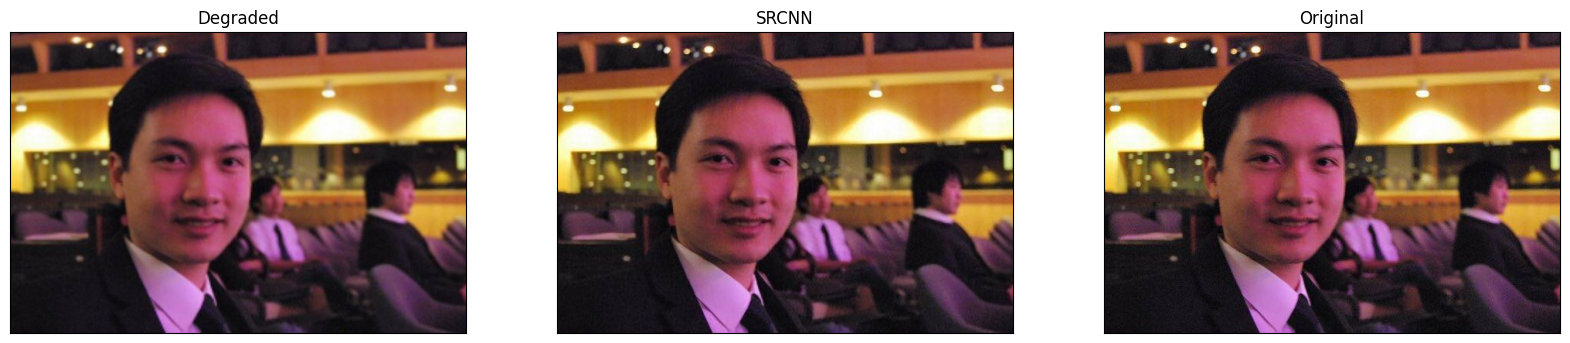

In [ ]:
ref, degraded, output, scores = predict('resized/test1.jpg')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[0].set_title('Degraded')
axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[1].set_title('SRCNN')
axs[2].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original')

# Save the predicted images
cv2.imwrite('saved_degraded.png', degraded)
cv2.imwrite('saved_output.png', output)
cv2.imwrite('saved_original.png', ref)
# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

1/1 [==============================] - 4s 4s/step


<ipython-input-5-cccb35a7b6e7>:27: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


Degraded Image: 
PSNR: 27.20239707489916
MSE: 371.5026432283313
SSIM: 0.8106732600307885

Reconstructed Image: 
PSNR: 28.348281831377182
MSE: 285.3470798314835
SSIM: 0.8692278697536681



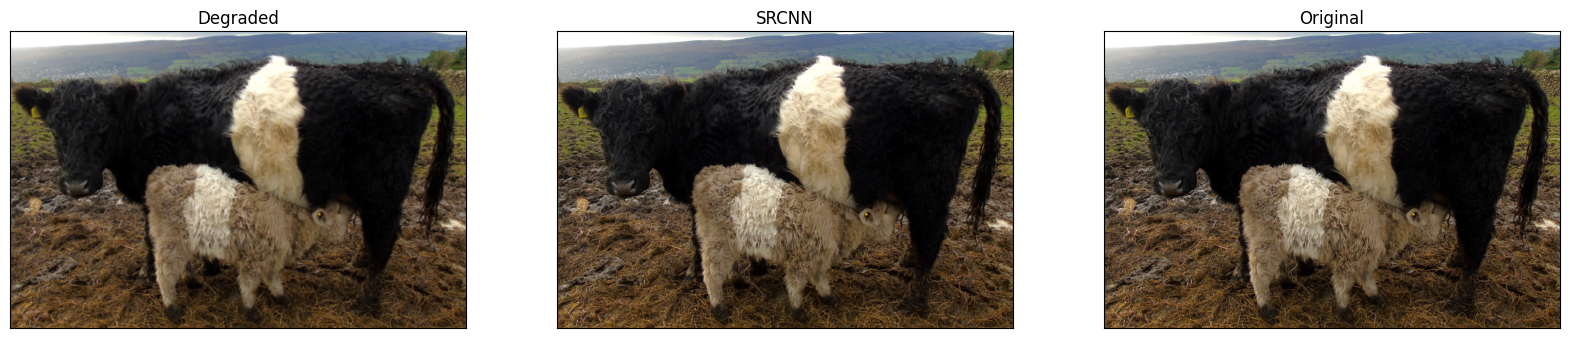

In [78]:
process_hr_image('origin/0000022.png')

# Non-local Means (NLM) Filter as Pre-processor

Pass input through NLM filter before SRCNN.

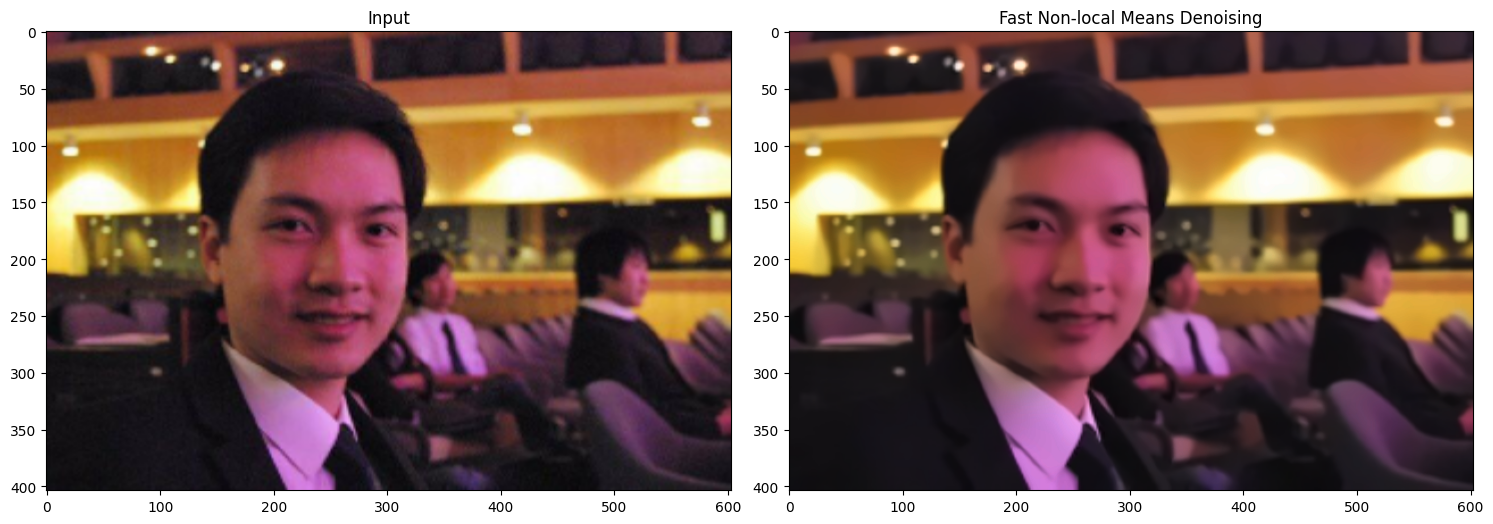

1/1 [==============================] - 1s 915ms/step
Degraded Image: 
PSNR: 33.312313909125976
MSE: 90.98508909169927
SSIM: 0.8796948747640329

Reconstructed Image: 
PSNR: 33.840621503910725
MSE: 80.56371142981313
SSIM: 0.8819480385517781



<ipython-input-5-cccb35a7b6e7>:27: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


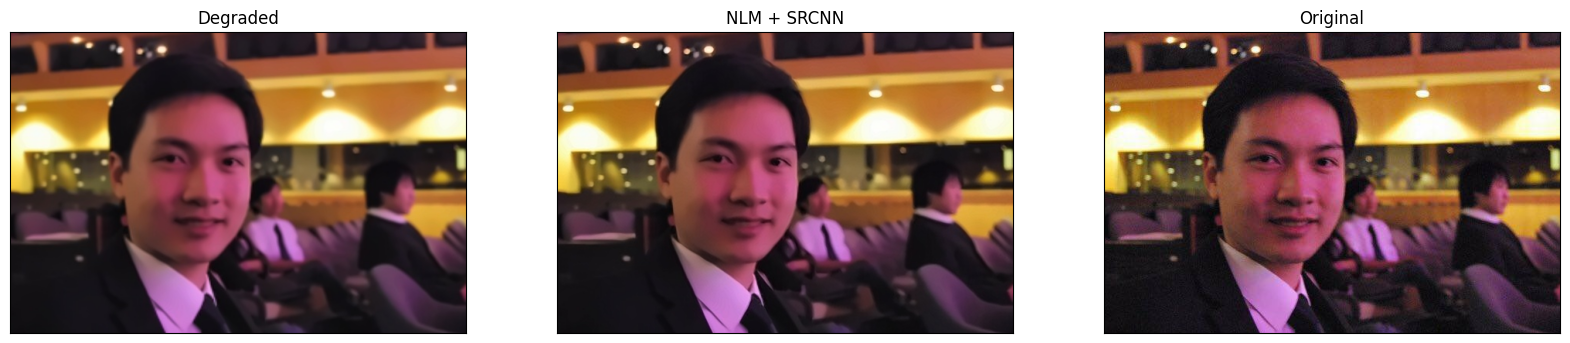

In [ ]:
img = cv2.imread('origin/test1.jpg')
# find old and new image dimensions
h, w, _ = img.shape

new_height = int(h / SCALE)
new_width = int(w / SCALE)

# resize the image - down
img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

# resize the image - up
img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

# pass through NLM filter
dst = cv2.fastNlMeansDenoisingColored(img, None, 7, 7, 7, 21) # recommend 10,10,7,21
row, col = 1, 2
fig, axs = plt.subplots(row, col, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Input')
axs[1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
axs[1].set_title('Fast Non-local Means Denoising')
plt.show()

# save the image
cv2.imwrite('resized/test1.jpg', dst)
################################################################################
# Predict
ref, degraded, output, scores = predict('resized/test1.jpg')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[0].set_title('Degraded')
axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[1].set_title('NLM + SRCNN')
axs[2].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original')

# Save the predicted images
cv2.imwrite('saved_degraded.png', degraded)
cv2.imwrite('saved_output.png', output)
cv2.imwrite('saved_original.png', ref)
# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

Oops! While noise were removed, the metrics show a decrease with NLM filtering. This could be due to NLM potentially removing some details along with noise.

It's also important to consider that PSNR, MSE, and SSIM might not always align perfectly with human perception of image quality.



1/1 [==============================] - 1s 1s/step


<ipython-input-5-cccb35a7b6e7>:27: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


Degraded Image: 
PSNR: 33.312313909125976
MSE: 90.98508909169927
SSIM: 0.8796948747640329

Reconstructed Image: 
PSNR: 33.840621503910725
MSE: 80.56371142981313
SSIM: 0.8819480385517781



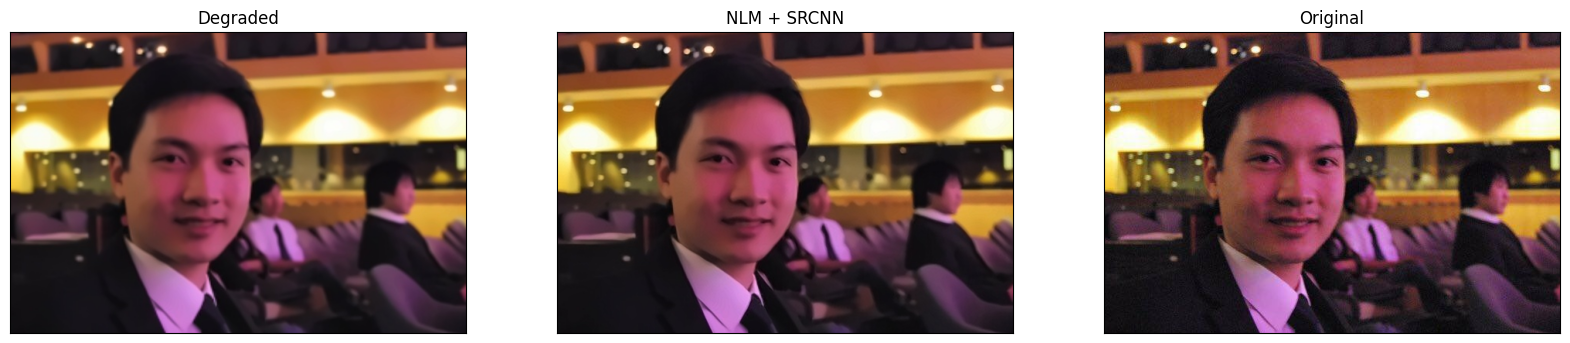

In [ ]:
# Predict
ref, degraded, output, scores = predict('resized/test1.jpg')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[0].set_title('Degraded')
axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[1].set_title('NLM + SRCNN')
axs[2].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[2].set_title('Original')

# Save the predicted images
cv2.imwrite('saved_degraded.png', degraded)
cv2.imwrite('saved_output.png', output)
cv2.imwrite('saved_original.png', ref)
# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

1/1 [==============================] - 7s 7s/step


<ipython-input-5-cccb35a7b6e7>:27: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


Degraded Image: 
PSNR: 32.62780518063253
MSE: 106.51753253915729
SSIM: 0.9105959247103113

Reconstructed Image: 
PSNR: 34.31729349661488
MSE: 72.18920613910687
SSIM: 0.9346023189614939



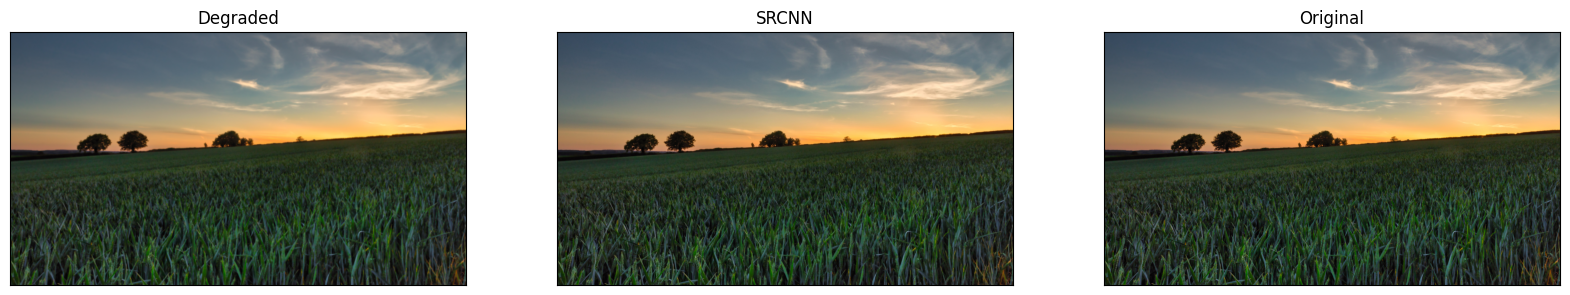

In [83]:
process_hr_image('origin/0000016.png')

In [84]:
# This function received path to LR image and predict
def process_lr_image(image_path, scale=2):
  path, file = os.path.split(image_path)
  # Read the image
  img = cv2.imread(image_path)
  cv2.imwrite('resized/{}'.format(file), img)
  ref, degraded, output, scores = predict('resized/{}'.format(file))

  print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

  fig, axs = plt.subplots(1, 2, figsize=(20, 8))
  axs[0].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
  axs[0].set_title('SRCNN')
  axs[1].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
  axs[1].set_title('Original')
  for ax in axs:
      ax.set_xticks([])
      ax.set_yticks([])

  # Save the predicted images
  # cv2.imwrite('saved_degraded.png', degraded)
  cv2.imwrite('saved_output.png', output)
  cv2.imwrite('saved_original.png', ref)

1/1 [==============================] - 4s 4s/step


<ipython-input-5-cccb35a7b6e7>:27: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


Reconstructed Image: 
PSNR: 21.65727122570859
MSE: 1331.908814348147
SSIM: 0.8514797259795603



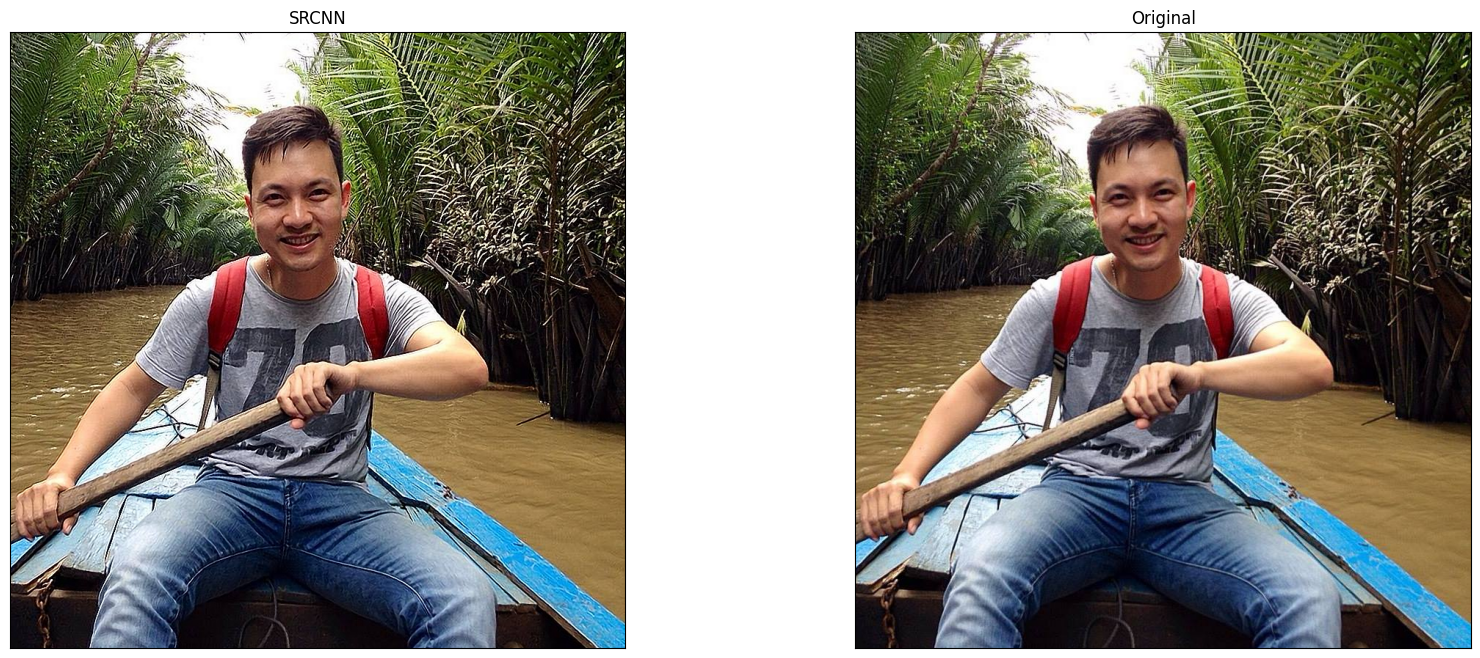

In [85]:
process_lr_image('origin/test002.jpg')